In [1]:
import os
import time
import pprint
import argparse
import torch
import numpy as np
import pickle
import utils
import csv

from model.hidden import Hidden
from noise_layers.noiser import Noiser
from average_meter import AverageMeter
from noise_argparser import NoiseArgParser

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

/home/master/10/jimmyliu/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir='/tmp2/jimmyliu/HiDDeN_experiment/dataset_10000'
#current_run='/tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-noise-256-adam 2023.05.20--02-44-07'
current_run="/tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-baseline-256-adam-mse 2023.05.26--16-28-10"
batch_size=2
round=True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
options_file = os.path.join(current_run, 'options-and-config.pickle')
train_options, hidden_config, _ = utils.load_options(options_file)
train_options.train_folder = os.path.join(data_dir, 'val')
train_options.validation_folder = os.path.join(data_dir, 'train')
train_options.batch_size = batch_size
noise_config=[]

In [4]:
checkpoint, chpt_file_name = utils.load_checkpoint('/tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-baseline-256-adam-mse 2023.05.26--16-28-10/checkpoints/combined-baseline-256-adam-mse--epoch-45.pyt')
print(f'Loaded checkpoint from file {chpt_file_name}')

noiser = Noiser(noise_config,device)
model = Hidden(hidden_config, device, noiser, tb_logger=None,train_options=train_options)
utils.model_from_checkpoint(model, checkpoint)
model.encoder_decoder.eval()

Loaded checkpoint from file /tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-baseline-256-adam-mse 2023.05.26--16-28-10/checkpoints/combined-baseline-256-adam-mse--epoch-45.pyt


EncoderDecoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (2): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (3): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel

In [5]:
_, val_data = utils.get_data_loaders(hidden_config, train_options)
file_count = len(val_data.dataset)
if file_count % train_options.batch_size == 0:
            steps_in_epoch = file_count // train_options.batch_size
else:
    steps_in_epoch = file_count // train_options.batch_size + 1

In [6]:
print(file_count)

10000


In [7]:

step = 0
losses_accu={}

ori_list_arr=[]
with torch.no_grad():
    for image, _ in val_data:
        
        image = image.to(device)
        #message = torch.Tensor(np.random.choice([0, 1], (image.shape[0], hidden_config.message_length))).to(device)
        decoded_messages= model.encoder_decoder.decoder(image)
        #decoded_messages=torch.sigmoid(decoded_messages)
        if step==0:
            ori_list_arr=decoded_messages.detach().cpu()
        else:
            ori_list_arr=torch.cat( (ori_list_arr,decoded_messages.detach().cpu()),0 )



        step += 1
        '''
        if step >=2:
            break
        '''

In [8]:

if round:
    ruond_ori_list_arr=ori_list_arr.round().clip(0, 1)

miu=torch.mean(ori_list_arr, 0)
round_miu=torch.mean(ruond_ori_list_arr, 0)

In [9]:
print(miu.mean())
print(round_miu.mean())
print(miu)
print(round_miu)

tensor(0.4561)
tensor(0.4129)
tensor([0.5777, 0.2696, 0.1968, 0.5630, 0.4421, 0.4201, 0.3615, 0.4696, 0.5482,
        0.3587, 0.5505, 0.5263, 0.2353, 0.2948, 0.4992, 0.5172, 0.4450, 0.4080,
        0.3882, 0.4557, 0.8279, 0.2726, 0.5313, 0.5552, 0.4034, 0.7544, 0.3847,
        0.3016, 0.3565, 0.3253, 0.2183, 0.6472, 0.5114, 0.6549, 0.5372, 0.5228,
        0.5926, 0.2790, 0.4318, 0.4807, 0.3132, 0.5270, 0.2958, 0.6969, 0.6324,
        0.1646, 0.6174, 0.5315])
tensor([8.1820e-01, 1.1000e-02, 3.0000e-03, 7.4960e-01, 1.5430e-01, 2.2180e-01,
        1.4900e-02, 3.4310e-01, 6.7910e-01, 3.7800e-02, 8.1560e-01, 6.1580e-01,
        6.0000e-04, 1.3000e-02, 4.8090e-01, 6.4520e-01, 1.3610e-01, 1.4970e-01,
        4.3800e-02, 2.7720e-01, 9.9760e-01, 2.0000e-03, 6.8010e-01, 7.9920e-01,
        2.3100e-01, 9.9550e-01, 5.1300e-02, 9.5000e-03, 4.0400e-02, 7.0500e-02,
        1.1700e-02, 9.8040e-01, 5.4420e-01, 9.9160e-01, 7.2030e-01, 5.9890e-01,
        9.7170e-01, 1.1800e-02, 2.7440e-01, 4.1600e-01, 2

In [10]:
ori_list_arr

tensor([[ 0.5615,  0.4233,  0.0133,  ...,  0.3774,  0.6938,  0.4661],
        [ 0.6627,  0.3340,  0.2176,  ...,  0.2465,  0.6332,  0.5881],
        [ 0.7543,  0.1583,  0.0899,  ...,  0.0260,  0.6483,  0.6578],
        ...,
        [ 0.6038,  0.3611,  0.2066,  ...,  0.1541,  0.6877,  0.5323],
        [ 0.5787,  0.3289,  0.1950,  ...,  0.2189,  0.6104,  0.5870],
        [ 0.8039,  0.1065,  0.1333,  ..., -0.1553,  0.8043,  0.6313]])

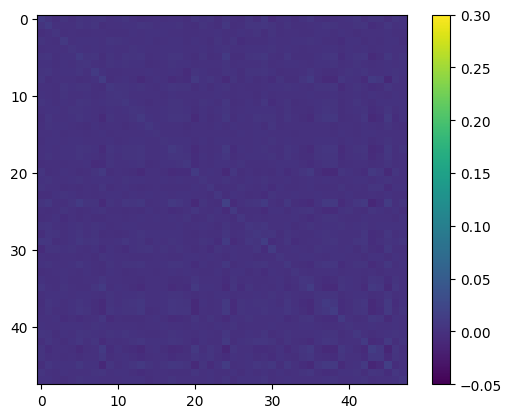

In [11]:
conv_matrix=torch.cov(ori_list_arr.T)

#plt.matshow(conv_matrix, cmap=plt.cm.Blues)
plt.imshow(conv_matrix,vmin=-0.05,vmax=0.3)
plt.colorbar()

plt.show()



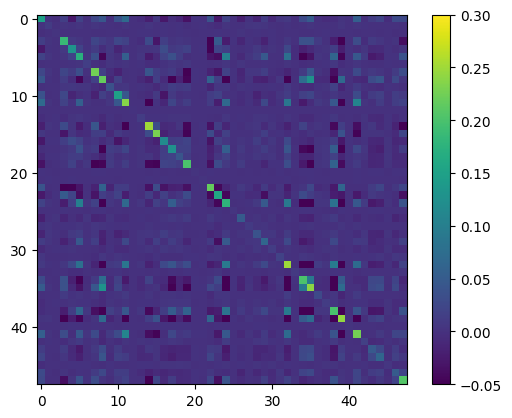

In [12]:
round_conv_matrix=torch.cov(ruond_ori_list_arr.T)

#plt.matshow(conv_matrix, cmap=plt.cm.Blues)
plt.imshow(round_conv_matrix,vmin=-0.05,vmax=0.3)
plt.colorbar()

plt.show()

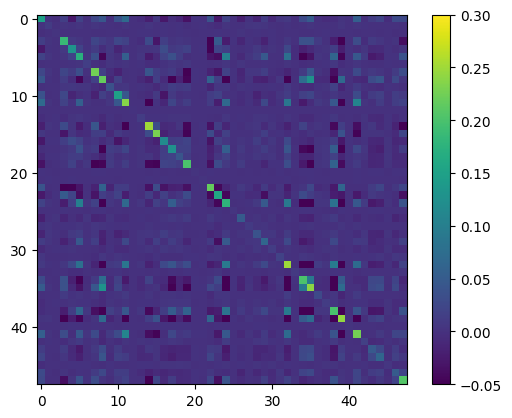

In [13]:
round_conv_matrix=torch.cov((ruond_ori_list_arr-miu).T)

#plt.matshow(conv_matrix, cmap=plt.cm.Blues)
plt.imshow(round_conv_matrix,vmin=-0.05,vmax=0.3)
plt.colorbar()

plt.show()

In [14]:
print(round_conv_matrix.T == round_conv_matrix)

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])


In [15]:
conv_matrix=(conv_matrix.T+conv_matrix)/2
print(torch.all(conv_matrix.T == conv_matrix))

tensor(True)


In [16]:
L, V = torch.linalg.eig(conv_matrix)
#L, V = torch.linalg.eigh(conv_matrix)
L_matrix=torch.diag_embed(1/torch.sqrt(L))
#b=-(L_matrix@V.T).to(torch.float)@(
# 
# -0.5)
b=-(L_matrix@V.T).to(torch.float)@miu
w=(L_matrix@V.T).to(torch.float)

eig_whitening_layer=nn.Linear(48,48)
eig_whitening_layer.weight=nn.Parameter(w)
eig_whitening_layer.bias=nn.Parameter(b)
eig_whitening_layer=eig_whitening_layer.to(device)
eig_whitening_layer.eval()

/tmp/ipykernel_64446/1834949585.py:7: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Copy.cpp:239.)
  b=-(L_matrix@V.T).to(torch.float)@miu


Linear(in_features=48, out_features=48, bias=True)

In [17]:
#L, V = torch.linalg.eig(conv_matrix)
L, V = torch.linalg.eigh(conv_matrix)
L_matrix=torch.diag_embed(1/torch.sqrt(L))

#b=-(L_matrix@V.T).to(torch.float)@(miu-0.5)
b=-(L_matrix@V.T)@miu
w=(L_matrix@V.T)

eigh_whitening_layer=nn.Linear(48,48)
eigh_whitening_layer.weight=nn.Parameter(w)
eigh_whitening_layer.bias=nn.Parameter(b)
eigh_whitening_layer=eigh_whitening_layer.to(device)
eigh_whitening_layer.eval()

Linear(in_features=48, out_features=48, bias=True)

In [27]:
eig_whitening_layer=torch.load('/tmp2/jimmyliu/whiten.pt')
eig_whitening_layer.eval()
eig_whitening_layer=eig_whitening_layer.to(device)

In [28]:

step = 0
losses_accu={}

eig_list_arr=[]

eigh_list_arr=[]
with torch.no_grad():
    for image, _ in val_data:
        
        image = image.to(device)
        #message = torch.Tensor(np.random.choice([0, 1], (image.shape[0], hidden_config.message_length))).to(device)
        decoded_messages= model.encoder_decoder.decoder(image)
        #decoded_messages=torch.sigmoid(decoded_messages)
        eig_decoded_messages=eig_whitening_layer(decoded_messages)
        eigh_decoded_messages=eigh_whitening_layer(decoded_messages)


        if step==0:
            eig_list_arr=eig_decoded_messages.detach().cpu()
            eigh_list_arr=eigh_decoded_messages.detach().cpu()
        else:
            eig_list_arr=torch.cat( (eig_list_arr,eig_decoded_messages.detach().cpu()),0 )
            eigh_list_arr=torch.cat( (eigh_list_arr,eigh_decoded_messages.detach().cpu()),0 )



        step += 1
       

In [29]:
print(decoded_messages)

tensor([[ 0.5787,  0.3289,  0.1950,  0.6196,  0.4265,  0.5387,  0.4142,  0.5616,
          0.4769,  0.4301,  0.5437,  0.4737,  0.2017,  0.3952,  0.5069,  0.4784,
          0.4600,  0.5139,  0.4389,  0.4170,  0.7456,  0.3646,  0.5593,  0.4915,
          0.4400,  0.7363,  0.3861,  0.2527,  0.4233,  0.3358,  0.1485,  0.6486,
          0.5209,  0.7156,  0.4781,  0.4768,  0.5930,  0.3040,  0.5405,  0.3347,
          0.3871,  0.5742,  0.3296,  0.6179,  0.5566,  0.2189,  0.6104,  0.5870],
        [ 0.8039,  0.1065,  0.1333,  0.7424,  0.4962,  0.4643,  0.3744,  0.6654,
          0.7360,  0.3147,  0.6476,  0.5020,  0.1918,  0.1259,  0.4156,  0.6313,
          0.3498,  0.3759,  0.2190,  0.1847,  1.0996,  0.0910,  0.5085,  0.5733,
          0.2188,  0.6534,  0.2662,  0.2690,  0.2673,  0.4385,  0.1453,  0.6145,
          0.3252,  0.6349,  0.6444,  0.7813,  0.5432, -0.0972,  0.2224,  0.5583,
          0.3797,  0.4473,  0.2778,  0.9512,  0.5589, -0.1553,  0.8043,  0.6313]],
       device='cuda:0')


In [30]:
print(eig_decoded_messages)

tensor([[ 0.7852,  0.2305, -0.0056,  0.5586, -1.2534, -0.1141,  0.1024,  0.2295,
         -1.1034,  0.3937,  1.5115, -0.9207,  1.1597,  1.7715, -0.2541, -0.1574,
         -0.7628,  0.1219, -0.3544,  1.1339, -0.8707, -0.1060, -1.3817,  0.0043,
          0.9902,  0.1502,  0.9744, -0.6402,  0.5257,  0.7005,  1.0143,  0.7743,
         -1.7629,  0.4426, -1.8748, -0.9958,  0.4996,  1.3315,  0.8229, -0.2195,
         -0.1724,  1.8835, -0.5040, -0.8887,  1.0363, -0.3632, -0.3718,  1.4763],
        [-2.1403,  1.5931, -0.6873,  0.8772, -2.5613, -0.0102, -1.8499,  3.9891,
          1.3095,  0.9350, -0.7762,  1.6868, -1.6247, -0.6894,  0.3561,  0.3799,
          1.3232,  1.1258,  1.1263,  0.8536,  1.2482,  0.3124, -0.6718, -0.0953,
         -1.0328, -0.7486, -0.5935, -0.7450,  1.1134,  0.1602, -0.7968,  0.8107,
          1.2869,  0.7787, -0.1657, -0.5779, -2.0865,  0.0945, -0.2420,  0.8722,
         -1.3184, -0.9463, -1.2655,  0.1738, -0.1368, -0.2070,  0.7451,  0.7504]],
       device='cuda:0')


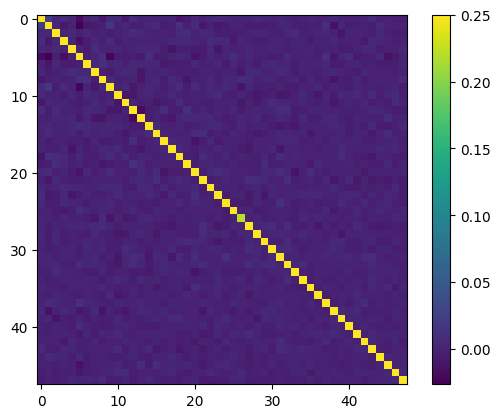

In [31]:
noround_eig_miu=torch.mean(eig_list_arr, 0)
noround_eigh_miu=torch.mean(eigh_list_arr, 0)

eig_list_arr=eig_list_arr/2+0.5
eigh_list_arr=eigh_list_arr/2+0.5
if round:
    eig_list_arr=eig_list_arr.round().clip(0, 1)
    eigh_list_arr=eigh_list_arr.round().clip(0, 1)

eig_conv_matrix=torch.cov((eig_list_arr).T)
plt.imshow(eig_conv_matrix)
plt.colorbar()

plt.show()

In [32]:
print(torch.diag(eig_conv_matrix))

tensor([0.2500, 0.2493, 0.2500, 0.2500, 0.2500, 0.2489, 0.2500, 0.2500, 0.2496,
        0.2496, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2499, 0.2500, 0.2499, 0.2500, 0.2500, 0.2500, 0.2478, 0.2496, 0.2227,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500])


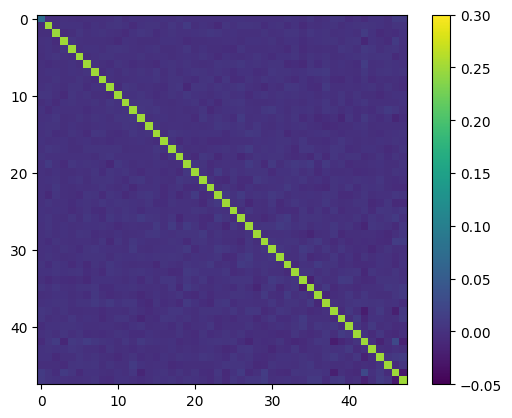

In [33]:
eigh_conv_matrix=torch.cov((eigh_list_arr).T)
plt.imshow(eigh_conv_matrix,vmin=-0.05,vmax=0.3)
plt.colorbar()

plt.show()

In [34]:
print(torch.diag(eigh_conv_matrix))
print(torch.diag(eig_conv_matrix))

tensor([0.0743, 0.2499, 0.2473, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2499, 0.2500, 0.2499, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2496, 0.2495, 0.2500, 0.2500, 0.2489, 0.2500, 0.2500,
        0.2500, 0.2493, 0.2500])
tensor([0.2500, 0.2493, 0.2500, 0.2500, 0.2500, 0.2489, 0.2500, 0.2500, 0.2496,
        0.2496, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2499, 0.2500, 0.2499, 0.2500, 0.2500, 0.2500, 0.2478, 0.2496, 0.2227,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500])


In [35]:
print(noround_eig_miu.mean())
print(noround_eigh_miu.mean())

tensor(0.0099)
tensor(0.0349)


In [36]:
torch.save(eig_whitening_layer,'whiten45.pt')

In [37]:
eig_whitening_layer=torch.load('eig.pt')